# Import Package and Functions

In [1]:
import jax
import jax.numpy  as jnp
from jax import lax
from jax import random
import numpy as np
import matplotlib.pyplot  as plt
import torch
import torchvision
import time
from torchvision import datasets, transforms
from jax.scipy.stats import mode
from sklearn.model_selection  import train_test_split

# Data Preprocess Functions

In [2]:
@jax.jit
def whiten_data(data):
    mean = jnp.mean(data,  axis=0)
    data_centered = data - mean
    cov = jnp.cov(data_centered,  rowvar=False)
    eigvals, eigvecs = jnp.linalg.eigh(cov)
    data_whitened = jnp.dot(data_centered,  eigvecs) / jnp.sqrt(eigvals  + 1e-8)
    return data_whitened

# Download CIFAR-10 Dataset
## Split train dataset to train dataset and validate dataset

In [3]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

X_train = np.array(train_dataset.data).transpose(0, 3, 1, 2)
y_train = np.array(train_dataset.targets)

X_test = np.array(test_dataset.data).transpose(0,  3, 1, 2)
y_test = np.array(test_dataset.targets)

X_train_jax = jnp.array(X_train  / 255.0)
X_test_jax = jnp.array(X_test  / 255.0)

y_train_jax = jnp.array(y_train)
y_test_jax = jnp.array(y_test)

X_train_jax = X_train_jax.reshape((X_train_jax.shape[0], -1))
X_test_jax = X_test_jax.reshape((X_test_jax.shape[0], -1))


100%|██████████| 170M/170M [00:05<00:00, 29.3MB/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [4]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

train_data = np.array(train_dataset.data)
train_labels = np.array(train_dataset.targets)
train_data = train_data.transpose(0, 3, 1, 2)

X_train, X_val, y_train, y_val = train_test_split(
    train_data, train_labels, test_size=0.2, random_state=42
)

X_test = np.array(test_dataset.data).transpose(0,  3, 1, 2)
y_test = np.array(test_dataset.targets)

X_train_jax = jnp.array(X_train  / 255.0)
X_val_jax = jnp.array(X_val  / 255.0)
X_test_jax = jnp.array(X_test  / 255.0)

y_train_jax = jnp.array(y_train)
y_val_jax = jnp.array(y_val)
y_test_jax = jnp.array(y_test)

X_train_jax = X_train_jax.reshape((X_train_jax.shape[0], -1))
# X_train_jax = whiten_data(X_train_jax)
X_val_jax = X_val_jax.reshape((X_val_jax.shape[0], -1))
# X_val_jax = whiten_data(X_val_jax)
X_test_jax = X_test_jax.reshape((X_test_jax.shape[0], -1))
# X_test_jax = whiten_data(X_test_jax)

Files already downloaded and verified
Files already downloaded and verified


In [5]:
@jax.jit
def compute_l2_distances(X_test, X_train):
    num_test = X_test.shape[0]
    num_train = X_train.shape[0]
    distances = jnp.zeros((num_test, num_train))
    X_test_squared = jnp.sum(X_test ** 2, axis=1, keepdims=True)
    X_train_squared = jnp.sum(X_train ** 2, axis=1, keepdims=True)
    inner_prod = jnp.dot(X_test, X_train.T)
    distances = jnp.sqrt(X_test_squared - 2 * inner_prod + X_train_squared.T)
    return distances

@jax.jit
def compute_cosine_similarity(X_test, X_train):
    num_test = X_test.shape[0]
    num_train = X_train.shape[0]
    inner_prod = jnp.dot(X_test,  X_train.T)
    norm_test = jnp.linalg.norm(X_test,  axis=1, keepdims=True)
    norm_train = jnp.linalg.norm(X_train,  axis=1, keepdims=True)
    cosine_sim = inner_prod / (norm_test * norm_train.T + 1e-8)
    return cosine_sim


@jax.jit
def k_nearest_neighbors(distances, k=3):
    sorted_indices = jnp.argsort(distances,  axis=1)
    def slice_row(row):
        return lax.dynamic_slice(row,  (0,), (k,))
    indices = jnp.apply_along_axis(slice_row,  1, sorted_indices)
    return indices


@jax.jit
def get_neighbor_labels(indices, y_train):
  neighbor_labels = y_train[indices]
  return neighbor_labels

@jax.jit
def majorith_voting(neighbor_labels):
  mode_results = mode(neighbor_labels, axis=1)
  predictions = mode_results.mode.reshape(-1)
  return predictions

@jax.jit
def predict(X_test, X_train_jax, y_train_jax):
  dist = compute_l2_distances(X_test, X_train_jax)
  indices = k_nearest_neighbors(dist)
  neighbor_labels = get_neighbor_labels(indices, y_train_jax)
  predictions = majorith_voting(neighbor_labels)
  return predictions

In [6]:
predicted_labels_test = predict(X_test_jax, X_train_jax, y_train_jax)
acc_test = jnp.mean(predicted_labels_test == y_test_jax)
print(f"Test Accuracy: {acc_test:.4f}")

Test Accuracy: 0.3213


In [7]:
start = time.time()
predicted_labels_val = predict(X_val_jax, X_train_jax, y_train_jax)
end = time.time()
print("Val time:", end - start)
acc_val = jnp.mean(predicted_labels_val == y_val_jax)
print(f"Validation Accuracy: {acc_val:.4f}")

predicted_labels_test = predict(X_test_jax, X_train_jax, y_train_jax)
acc_test = jnp.mean(predicted_labels_test == y_test_jax)
print(f"Test Accuracy: {acc_test:.4f}")

Validation Accuracy: 0.3215
Test Accuracy: 0.3213


|# DataSet Visualization

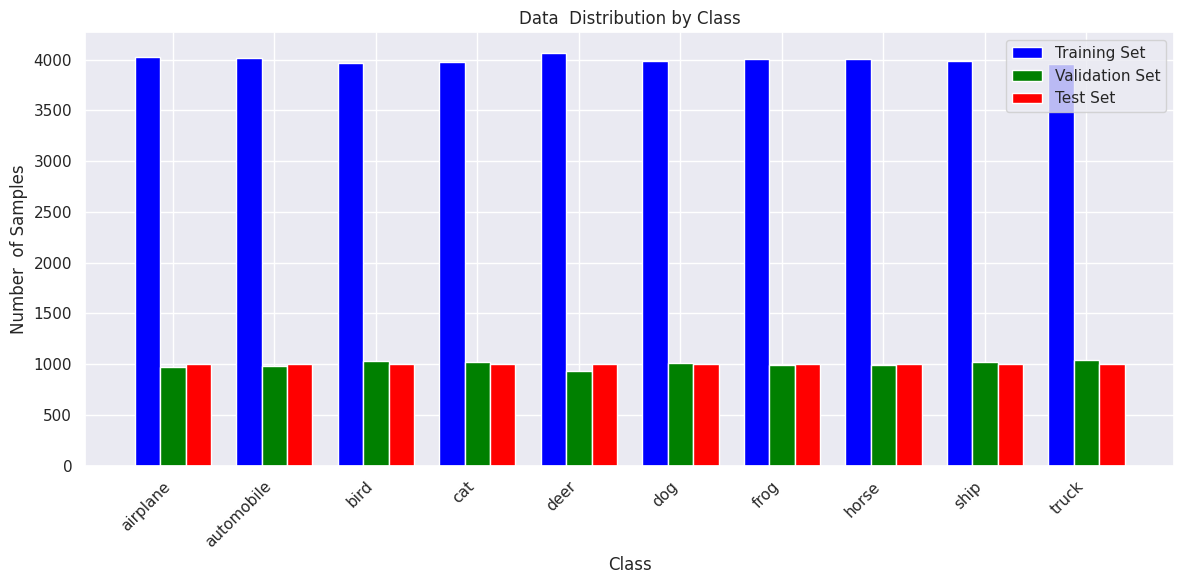

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<Figure size 640x480 with 0 Axes>

In [ ]:
import matplotlib.pyplot  as plt
import numpy as np
import seaborn as sns
from google.colab import files

sns.set()

class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

def count_samples(labels):
    counts = np.bincount(labels)
    return counts

train_counts = count_samples(y_train)
val_counts = count_samples(y_val)
test_counts = count_samples(y_test)

plt.figure(figsize=(12,  6))

bar_width = 0.25
index = np.arange(len(class_names))

plt.bar(index,  train_counts, bar_width, label='Training Set', color='blue')

plt.bar(index  + bar_width, val_counts, bar_width, label='Validation Set', color='green')

plt.bar(index  + 2*bar_width, test_counts, bar_width, label='Test Set', color='red')

plt.title('Data  Distribution by Class')
plt.xlabel('Class')
plt.ylabel('Number  of Samples')

plt.xticks(index  + bar_width, class_names, rotation=45, ha='right')

plt.legend()

plt.tight_layout()

plt.show()

plt.savefig("dataset.jpg")
files.download('dataset.jpg')


# Random Image Visualization

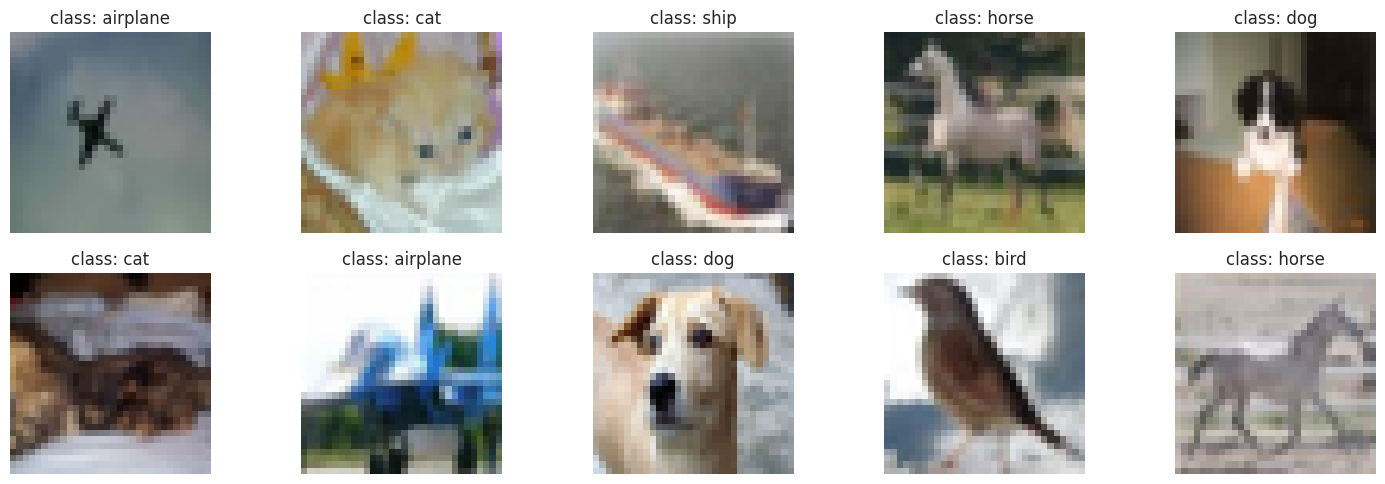

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import seaborn as sns

sns.set()

# Function to visualize random images
def visualize_random_images(dataset, num_images=10):
    # Randomly select indices
    indices = np.random.choice(len(dataset), num_images, replace=False)

    # Create a grid of subplots
    plt.figure(figsize=(15, 5))
    for i, idx in enumerate(indices):
        image, label = dataset[idx]  # Get the image and label

        # Convert image tensor to numpy array and denormalize
        image = image.numpy().transpose((1, 2, 0))  # Convert from (C, H, W) to (H, W, C)
        image = (image * 0.5) + 0.5  # Denormalize from [-1, 1] to [0, 1]

        # Plot the image
        plt.subplot(2, num_images // 2, i + 1)
        plt.imshow(image)
        plt.title(f"class: {class_names[label]}")
        plt.axis('off')

    plt.tight_layout()
    plt.show()

# Visualize random images from the training set
visualize_random_images(train_dataset, num_images=10)